In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

import random
from collections import Counter
import utilities.plotting_style as pstyle

pstyle.apply_style()  # uses your module defaults (fonts, palette, cmap, etc.)

PlotFonts(base=None, bold=None)

In [19]:
album = set()
dupes = Counter()

In [48]:
len_album = 1_000
len_packet = 5
order_stickers = 25
free_stickers = 6
exchange_efficiency = .25
packet_price = 0.8
postage_cost = 0.5
max_trade = 10


In [49]:
all_stickers = list(range(1, len_album+1))

In [50]:
first_free = random.sample(all_stickers, free_stickers)

album.update(first_free)

In [51]:
trade_size = list(range(1, 11))
buy_cost_per_sticker = packet_price / len_packet
trade_cost_per_sticker = [postage_cost / x for x in trade_size]

min_trade = min([i for (i, x) in zip(trade_size, trade_cost_per_sticker) if x <= buy_cost_per_sticker])
print(min_trade)

4


In [52]:
n_simulations = 10_000
num_packets, buy_cost, total_from_packets = [], [], []
num_trades, trade_cost, total_from_trades = [], [], []
total_ordered, total_cost, buy_v_trade = [], [], []


In [53]:
for _ in range(n_simulations):

    # --- reset per-simulation state ---
    album = set(random.sample(all_stickers, free_stickers))
    dupes = Counter()

    n_packets = 0
    n_trades = 0
    cost_packets = 0.0
    cost_postage = 0.0

    # cumulative contribution counters (new unique stickers gained)
    stickers_from_packets = 0
    stickers_from_trade = 0

    # per-packet contribution timeline
    packet_gains = []
    trade_gains_after_packet = []

    missing_count = len_album - len(album)

    while missing_count > order_stickers:

        # --------------------
        # BUY / OPEN PACKET
        # --------------------
        packet = random.sample(all_stickers, len_packet)
        n_packets += 1
        cost_packets += packet_price

        before_packet = len(album)

        new_dupes = [s for s in packet if s in album]
        dupes.update(new_dupes)
        album.update(packet)

        packet_gain = len(album) - before_packet
        stickers_from_packets += packet_gain

        packet_gains.append(packet_gain)
        trade_gains_after_packet.append(0)

        missing_count = len_album - len(album)
        total_dupes = len(dupes)  # distinct dupes (max 1 per sticker per trade)

        # --------------------
        # TRADING (optional)
        # --------------------
        if total_dupes < (min_trade / exchange_efficiency):
            continue

        trade_size = min(random.choice(range(1, total_dupes + 1)), max_trade, missing_count)

        still_missing = list(set(all_stickers) - album)
        trade_size = min(trade_size, len(still_missing))

        new_from_trade = random.sample(still_missing, trade_size)
        trade_away = random.sample(list(dupes.keys()), trade_size)

        cost_postage += postage_cost
        n_trades += 1

        before_trade = len(album)
        album.update(new_from_trade)
        trade_gain = len(album) - before_trade

        stickers_from_trade += trade_gain
        trade_gains_after_packet[-1] += trade_gain

        dupes.subtract(trade_away)
        dupes += Counter()

        missing_count = len_album - len(album)

    # --------------------
    # Crossover indices (contribution-based)
    # --------------------
    delta = [t - p for p, t in zip(packet_gains, trade_gains_after_packet)]

    # first time trades match/beat packet contribution
    start_trade_idx = next((i for i, d in enumerate(delta) if d >= 0), None)

    # last time packets strictly beat trades
    last_buy_dominant_idx = next((i for i in range(len(delta) - 1, -1, -1) if delta[i] < 0), None)

    buy_v_trade.append((start_trade_idx, last_buy_dominant_idx))

    # --- store results for this simulation ---
    num_packets.append(n_packets)
    buy_cost.append(cost_packets)
    total_from_packets.append(stickers_from_packets)

    num_trades.append(n_trades)
    trade_cost.append(cost_postage)
    total_from_trades.append(stickers_from_trade)

    total_ordered.append(len_album - stickers_from_packets - stickers_from_trade - free_stickers)
    total_cost.append(cost_packets + cost_postage)

    # (optional) store timelines per simulation if you want later analysis:
    # all_packet_gains.append(packet_gains)
    # all_trade_gains_after_packet.append(trade_gains_after_packet)

In [54]:
results_dict = {
    'len_album': len_album,
    'order_stickers': order_stickers,
    'free_stickers': free_stickers,
    'exchange_efficiency': exchange_efficiency,
    'packet_price': packet_price,
    'postage_cost': postage_cost,
    'num_packets': num_packets,
    'buy_cost': buy_cost,
    'total_from_packets': total_from_packets,
    'num_trades': num_trades,
    'trade_cost': trade_cost,
    'total_from_trades': total_from_trades,
    'total_ordered': total_ordered,
    'total_cost': total_cost,
    'buy_v_trade': buy_v_trade
}

In [55]:
results_df = pd.DataFrame(results_dict)
results_df[['start_trading', 'stop_buying']] = pd.DataFrame(results_df['buy_v_trade'].tolist(), index=results_df.index)

In [56]:
results_df.head()

,len_album,order_stickers,free_stickers,exchange_efficiency,packet_price,postage_cost,num_packets,buy_cost,total_from_packets,num_trades,trade_cost,total_from_trades,total_ordered,total_cost,buy_v_trade,start_trading,stop_buying
0,1000,25,6,0.25,0.8,0.5,197,157.6,523,66,33.0,455,16,190.6,"(43, 182)",43,182
1,1000,25,6,0.25,0.8,0.5,196,156.8,530,55,27.5,440,24,184.3,"(40, 191)",40,191
2,1000,25,6,0.25,0.8,0.5,196,156.8,484,68,34.0,485,25,190.8,"(27, 186)",27,186
3,1000,25,6,0.25,0.8,0.5,196,156.8,507,63,31.5,466,21,188.3,"(34, 189)",34,189
4,1000,25,6,0.25,0.8,0.5,197,157.6,511,61,30.5,464,19,188.1,"(36, 193)",36,193


In [57]:
results_df[
    [
        'num_packets', 'buy_cost', 'total_from_packets', 'num_trades', 'trade_cost',
        'total_from_trades', 'total_cost', 'total_ordered', 'start_trading', 'stop_buying',
    ]
].describe()

,num_packets,buy_cost,total_from_packets,num_trades,trade_cost,total_from_trades,total_cost,total_ordered,start_trading,stop_buying
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,196.613100,157.290480,506.911400,62.740500,31.370250,466.024400,188.660730,21.064200,36.713700,187.479800
std,0.673093,0.538474,12.744151,3.635145,1.817573,13.077871,1.969496,2.871289,4.335644,5.497292
min,195.000000,156.000000,440.000000,49.000000,24.500000,414.000000,181.800000,13.000000,22.000000,162.000000
25%,196.000000,156.800000,498.000000,60.000000,30.000000,457.000000,187.300000,19.000000,34.000000,184.000000
50%,197.000000,157.600000,507.000000,63.000000,31.500000,466.000000,188.600000,21.000000,37.000000,188.000000
75%,197.000000,157.600000,516.000000,65.000000,32.500000,475.000000,190.100000,24.000000,40.000000,192.000000
max,199.000000,159.200000,555.000000,79.000000,39.500000,534.000000,197.100000,25.000000,54.000000,196.000000


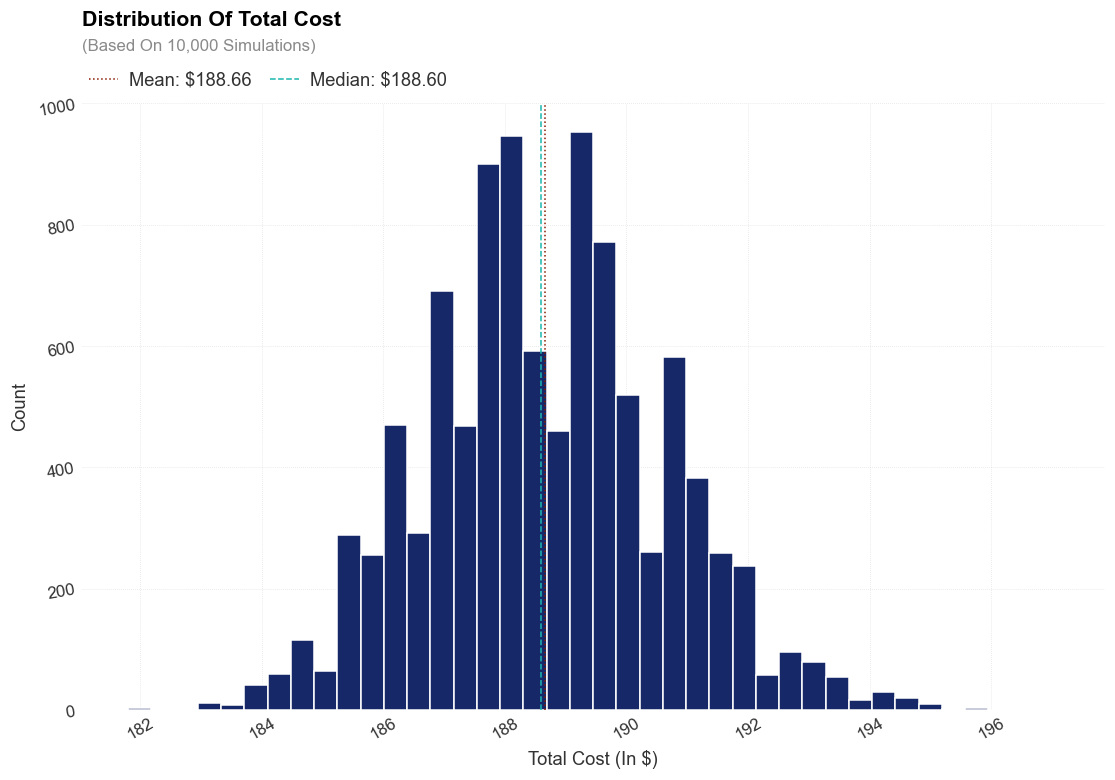

In [58]:
fig, ax = plt.subplots()

mean_cost = results_df["total_cost"].mean()
median_cost = results_df["total_cost"].median()

ax.hist(results_df["total_cost"], bins=40)
ax.axvline(mean_cost, linewidth=1, linestyle="dotted", color="#881C00FF", label=f"Mean: ${mean_cost:,.2f}")
ax.axvline(median_cost, linewidth=1, linestyle="dashed", color="#1BB6AFFF", label=f"Median: ${median_cost:,.2f}")

pstyle.set_title(ax, "Distribution of Total Cost", f"(based on {n_simulations:,} simulations)")
ax.set_xlabel("Total Cost (in $)")
ax.set_ylabel("Count")

ax.legend(frameon=False)
pstyle.style_plot(ax, format_thousands_axis="x")

plt.show()

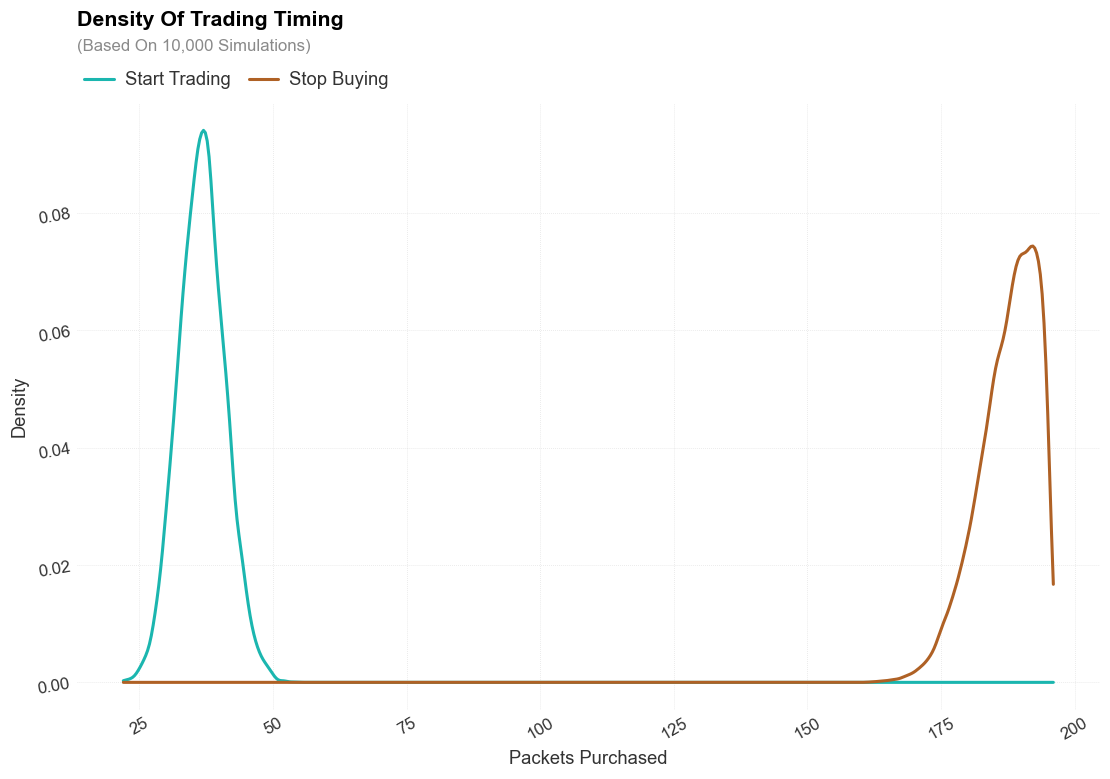

In [59]:
x1 = results_df["start_trading"].dropna().to_numpy()
x2 = results_df["stop_buying"].dropna().to_numpy()

# x-grid for plotting
xmin = min(x1.min(), x2.min())
xmax = max(x1.max(), x2.max())
xs = np.linspace(xmin, xmax, 500)

kde_start = gaussian_kde(x1)
kde_stop = gaussian_kde(x2)

fig, ax = plt.subplots()
ax.plot(xs, kde_start(xs), label="Start Trading", color = '#1BB6AFFF')
ax.plot(xs, kde_stop(xs), label="Stop Buying", color = '#AF6125FF') 

pstyle.set_title(ax, "Density of Trading Timing", f"(based on {n_simulations:,} simulations)")
ax.set_xlabel("Packets Purchased")
ax.set_ylabel("Density")

ax.legend(frameon=False)
pstyle.style_plot(ax, format_thousands_axis="x")

plt.show()

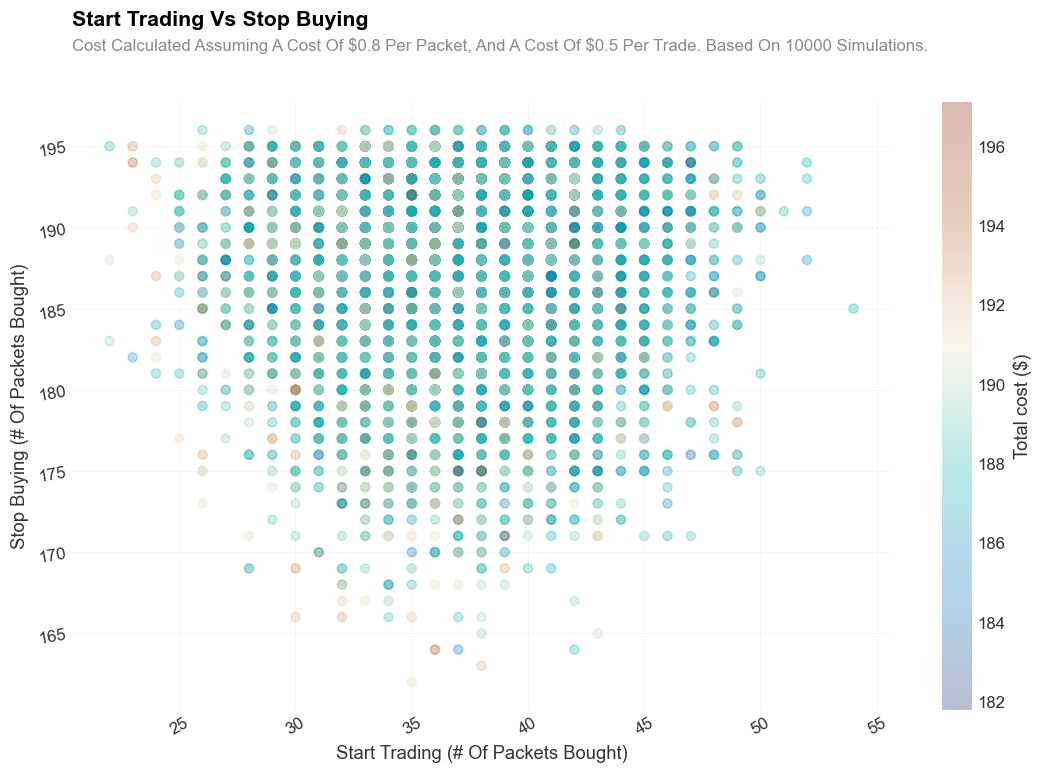

In [61]:
fig, ax = plt.subplots()

sc = ax.scatter(
    results_df["start_trading"],
    results_df["stop_buying"],
    c=results_df["total_cost"],
    alpha=0.3,
)

pstyle.set_title(ax, "Start trading vs stop buying", f"Cost calculated assuming a cost of \\${packet_price} per packet, and a cost of \\${postage_cost} per trade. Based on {n_simulations} simulations.")
ax.set_xlabel("Start trading (# of packets bought)")
ax.set_ylabel("Stop Buying (# of packets bought)")

pstyle.style_plot(ax, format_thousands_axis=None)  # or "x"/"y" if you want commas on axes too

cbar = fig.colorbar(sc, ax=ax)
cbar.set_label("Total cost ($)")

plt.show()

In [62]:
g = (
    results_df
    .dropna(subset=["start_trading", "total_cost"])
    .groupby("start_trading")["total_cost"]
    .agg(n="count", mean="mean", std="std")
    .reset_index()
    .sort_values("start_trading")
)

# 95% CI for the mean: mean ± 1.96 * (std / sqrt(n))
se = g["std"] / np.sqrt(g["n"])
g["ci_low"] = g["mean"] - 1.64 * se
g["ci_high"] = g["mean"] + 1.64 * se

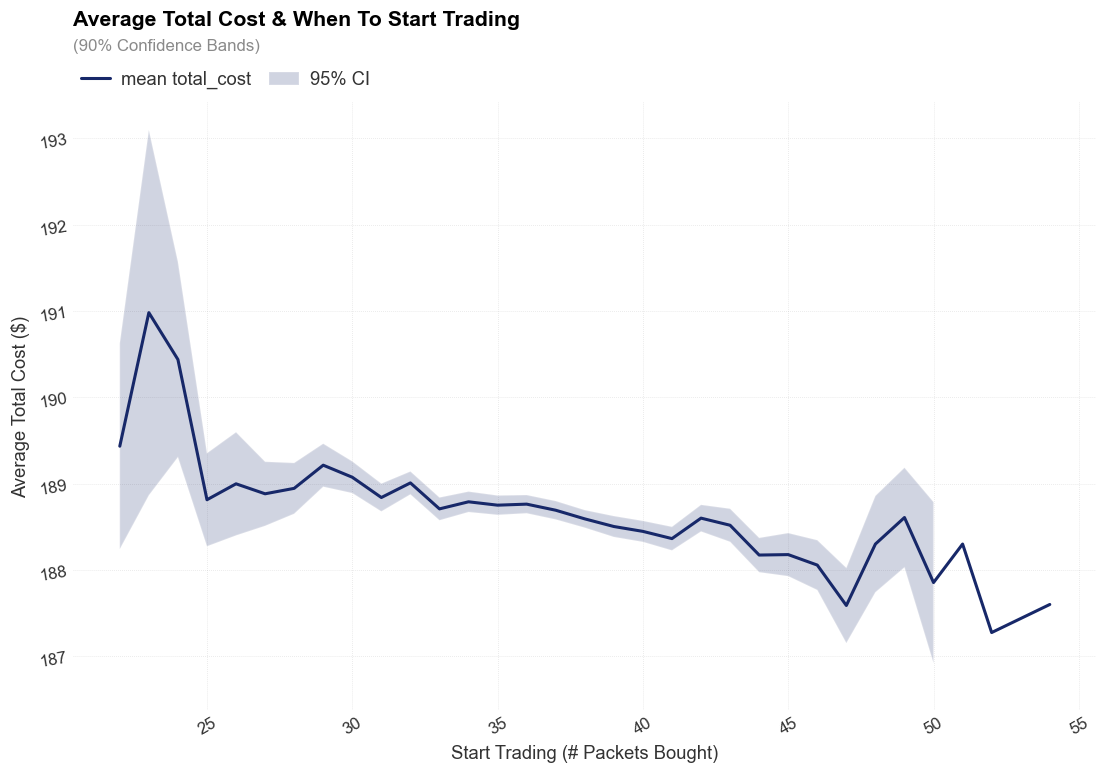

In [63]:

fig, ax = plt.subplots()

ax.plot(g["start_trading"], g["mean"], label="mean total_cost")
ax.fill_between(g["start_trading"], g["ci_low"], g["ci_high"], alpha=0.2, label="95% CI")

pstyle.set_title(ax, "Average Total Cost & When to Start Trading", "(90% confidence bands)")
ax.set_xlabel("Start Trading (# Packets bought)")
ax.set_ylabel("Average Total Cost ($)")

ax.legend(frameon=False)
pstyle.style_plot(ax, format_thousands_axis="y")

plt.show()